In [1]:
import warnings

# Suppress specific warnings from torchani
warnings.filterwarnings("ignore", message="mnp not installed")
warnings.filterwarnings("ignore", message="cuaev not installed")

from torchani.datasets import ANIDataset, ANIExCorr
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchani.orbitalfeatures.orbital_aev import OrbitalAEVComputer
from pathlib import Path


/home/jota/Programas/mambaforge/envs/ani-dev/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
caseprefix='methanol-exc'
dspath=f'/home/jsemelak/data/{caseprefix}/{caseprefix}.h5'
nlpath=f'/home/jsemelak/Programs/torchani_sandbox/torchani/orbitalfeatures/tests/normalization_library.pt'
# dspath=f'/home/jsemelak/data/{caseprefix}/1.h5'
prefix='/media/jota/cachirulo/1-EXC/1-DS/data'
dspath=f'{prefix}/{caseprefix}/{caseprefix}.h5'
nlpath=f'{prefix}/water-sp-exc/normalization_library.pt'
print(dspath)
ds = ANIDataset(dspath)
list(ds.keys())
keys=list(ds.keys())[0:3]
print(keys)
nl=torch.load(Path(nlpath))
nl[:,1,:]=nl[:,3,:] #For now just normalize C coefs with O mus and sigmas

/media/jota/cachirulo/1-EXC/1-DS/data/methanol-exc/methanol-exc.h5
['006']


In [ ]:
#Get atom-wize AEVs
tensors_O_list=[]
tensors_C_list=[]
tensors_H_list=[]
for key in keys:
    print(f"Processing: {key}")
    group = ds[key]
    coefficients=group['coefficients']
    iterations=group['iteration_idx']
    species=group['species']

    species=species[iterations == 0]
    coefficients=coefficients[iterations == 0]

    # Instantiate the orbital AEV computer
    orbital_aev_computer = OrbitalAEVComputer()

    # Compute the orbital AEVs
    aevs = orbital_aev_computer(
            normalization_library=nl,
            species=species,
            coefficients=coefficients,
            basis_functions='spd',
            use_simple_orbital_aev=False,
            use_angular_info=True,  # or False, as desired
            use_angular_radial_coupling=False,  # or False, as desired
            NOShfS=16,
            NOShfR=16,
            NOShfA=8,
            NOShfTheta=4,
            LowerOShfS=-4.0,
            UpperOShfS=4.0,
            LowerOShfR=-2.0,
            UpperOShfR=2.0,
            LowerOShfA=-2.0,
            UpperOShfA=2.0,
            LowerOShfTheta = -1.0,
            UpperOShfTheta = 1.0,
            OEtaS=5.0,
            OEtaR=5.0,
            OEtaA=5.0,
            OZeta=2.0,
    )

    mask_O = species[:, :] == 8
    mask_C = species[:, :] == 6
    mask_H = species[:, :] == 1

    nconformers, natoms, ncoefs = aevs.shape

    for i in range(0,nconformers):
        aevs_current=aevs[i]
        aevs_O_current=aevs_current[mask_O[i],:]
        tensors_O_list.append(aevs_O_current)
        aevs_C_current=aevs_current[mask_C[i],:]
        tensors_C_list.append(aevs_C_current)
        aevs_H_current=aevs_current[mask_H[i],:]
        tensors_H_list.append(aevs_H_current)
    
aevs_H = torch.cat(tensors_H_list, dim=0)
aevs_C = torch.cat(tensors_C_list, dim=0)
aevs_O = torch.cat(tensors_O_list, dim=0)
print("Shapes:", aevs_H.shape,aevs_C.shape,aevs_O.shape)

# To save the tensor to a file
torch.save(aevs_H, 'aevs_H.pt')
torch.save(aevs_C, 'aevs_C.pt')
torch.save(aevs_O, 'aevs_O.pt')

# To load the tensor:
aevs_O = torch.load('aevs_O.pt')
aevs_H = torch.load('aevs_H.pt')
aevs_C = torch.load('aevs_C.pt')
aevs_O_np=aevs_O.numpy()
aevs_H_np=aevs_H.numpy()
aevs_C_np=aevs_C.numpy()

Processing: 006
S SHAPE:  torch.Size([10, 6, 9, 16])
nangles:  6
OShfTheta tensor([-1.0000, -0.3333,  0.3333,  1.0000], dtype=torch.float64)
angular_orbital_aev shape: torch.Size([10, 6, 6, 4])
angular_orbital_aev shape: torch.Size([10, 6, 6, 4, 1])
Shapes: torch.Size([40, 232]) torch.Size([10, 232]) torch.Size([10, 232])


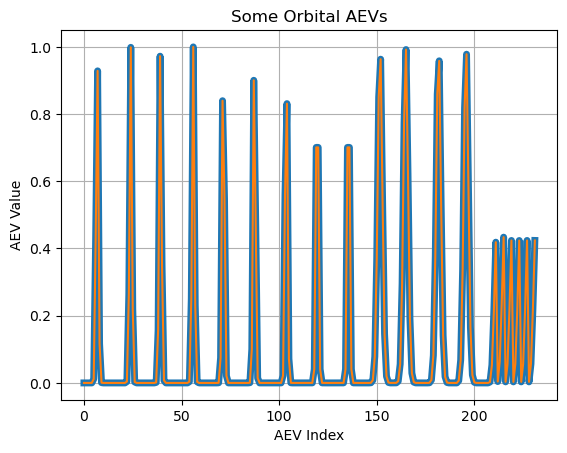

In [21]:
# index=0 # Change this index to plot different atoms
# plt.plot(aevs_O_np[index,:],linewidth=5)
# plt.plot(aevs_O_np[index+1,:])
# plt.title('Some Orbital AEVs')
# plt.xlabel('AEV Index')
# plt.ylabel('AEV Value')
# plt.grid() 
# plt.show()

index=0 # Change this index to plot different atoms
plt.plot(aevs_O_np[index,:],linewidth=5)
plt.plot(aevs_O_np[index+1,:])
plt.title('Some Orbital AEVs')
plt.xlabel('AEV Index')
plt.ylabel('AEV Value')
plt.grid() 
plt.show()
